In [34]:
%run imports.ipynb
%run utility_functions.ipynb
#%run setup.ipynb
import matplotlib.patches as mpatches

2017-01-30 17:06:21.375764 :: AgamP3 reference genome not available
2017-01-30 17:06:21.378046 :: AgamP4 reference genome not available


# Let's collect some descriptive stats on phase 2
e.g.

- diff between sp

In [35]:
callset_fn_template = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/raw/ag1000g.phase2.ar1.{chrom}.h5'
callset_pass_fn_template = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/pass/ag1000g.phase2.ar1.pass.{chrom}.h5'
callset_biallelic_fn_template = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/biallelic/ag1000g.phase2.ar1.biallelic.{chrom}.h5'
callset_ar2_fn_template = '/kwiat/vector/ag1000g/release/phase1.AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.{chrom}.h5'
accessibility = h5py.File('/kwiat/vector/ag1000g/release/phase2.AR1/accessibility/accessibility.h5', mode='r')
accessibility_p1 = h5py.File('/kwiat/vector/ag1000g/release/phase1.AR3/accessibility/accessibility.h5', mode='r')
release_dir = '/kwiat/vector/ag1000g/release/phase1.AR3'
genome_fn = os.path.join(release_dir, 'genome', 'Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa')
genome = pyfasta.Fasta(genome_fn)
genome

# 1. raw SNP counts

In [3]:
p1_raw_tot = 0
for chrom in sorted(genome.keys()):
    raw = callset_fn_template.format(chrom=chrom)
    callset = h5py.File(raw, mode='r')
    rawp = len(callset[chrom]['variants']['POS'][:])
    p1_raw_tot += rawp
    log(chrom, rawp)
log('total', p1_raw_tot)

2016-12-12 15:16:09.073181 :: 2L 21442865
2016-12-12 15:16:16.155902 :: 2R 24767689
2016-12-12 15:16:19.683547 :: 3L 18167056
2016-12-12 15:16:23.243527 :: 3R 24943504
2016-12-12 15:16:24.272533 :: UNKN 6759497
2016-12-12 15:16:25.682077 :: X 9389639
2016-12-12 15:16:25.827453 :: Y_unplaced 16448
2016-12-12 15:16:25.828516 :: total 105486698


# 2.0. Accessibility p1 vs. p2

In [4]:
#set up arrays for count and percentage accessible
p1_acc = np.empty([5,3], dtype=object)
p1_acc[:,0] = p1_acc[:,0].astype(str)
p2_acc = np.empty([5,3], dtype=object)
p2_acc[:,0] = p2_acc[:,0].astype(str) 

In [5]:
#remember 
count = 0
for chrom in '2L', '2R', '3L', '3R', 'X':
    
    #is_acc_p2 = np.count_nonzero(accessibility[chrom]['is_accessible'][:])
    p1_acc[count,0] = chrom
    p1_acc[count,1] = np.count_nonzero(accessibility_p1[chrom]['is_accessible'][:])
    p1_acc[count,2] = (p1_acc[count,1] / len(genome[chrom])) * 100
    
    p2_acc[count,0] = chrom
    p2_acc[count,1] = np.count_nonzero(accessibility[chrom]['is_accessible'][:])
    p2_acc[count,2] = (p2_acc[count,1] / len(genome[chrom])) * 100
    
    count += 1

In [6]:
#chromo arm, number of accessible bases, % of bases accessible
p1_acc

array([['2L', 28337781, 57.405385366861594],
       ['2R', 40226694, 65.36132158682643],
       ['3L', 25210747, 60.07789162159865],
       ['3R', 32878411, 61.8007298552778],
       ['X', 14812243, 60.72306571183959]], dtype=object)

In [7]:
p2_acc

array([['2L', 28193050, 57.11219590260781],
       ['2R', 39534863, 64.23721756588115],
       ['3L', 24946488, 59.44815528090109],
       ['3R', 32436343, 60.96978565162809],
       ['X', 14606989, 59.881623120760175]], dtype=object)

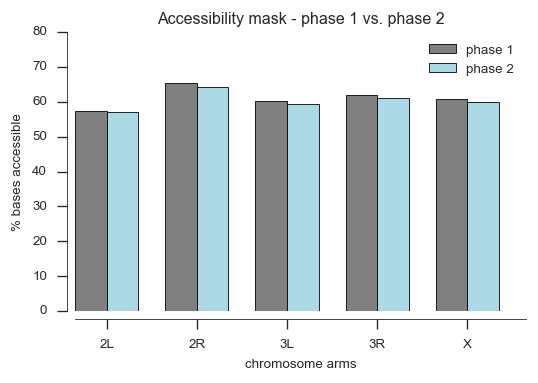

In [8]:
N = 5
p1 = p1_acc[:,2]

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5, bottom=False, top=True)
rects1 = ax.bar(ind, p1, width, color='gray')

p2 = p2_acc[:,2]

rects2 = ax.bar(ind + width, p2, width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_ylabel('% bases accessible')
ax.set_xlabel('chromosome arms')
ax.set_title('Accessibility mask - phase 1 vs. phase 2')
ax.set_xticks(ind + width)
ax.set_ylim(0,80)
ax.set_xticklabels(('2L', '2R', '3L', '3R', 'X'))

ax.legend((rects1[0], rects2[0]), ('phase 1', 'phase 2'))



plt.show()

# 2.1. Accessibility p1 vs. p2 - windowed

In [84]:
def plot_acc_p1_p2(chrom):
    is_accessible_p2 = accessibility[chrom]['is_accessible'][:]
    is_accessible_p1 = accessibility_p1[chrom]['is_accessible'][:]
    
    p = range(0,len(is_accessible_p2))

    x2, windows2, counts2 = allel.stats.window.windowed_statistic(p, is_accessible_p2, statistic=np.count_nonzero, size=100000, start=None, stop=None, step=None, windows=None)
    x1, windows1, counts1 = allel.stats.window.windowed_statistic(p, is_accessible_p1, statistic=np.count_nonzero, size=100000, start=None, stop=None, step=None, windows=None)
    
    z2 = np.mean(windows2, axis=1)
    z1 = np.mean(windows1, axis=1)
    
    fig, ax = subplots(figsize=(12, 4))
    
    ax.plot(z2, x2, color='lightblue')
    ax.plot(z1, x1, color='gray')
    plt.title(chrom+' accessibility')
    plt.ylabel('accessible_bases')
    plt.xlabel('chromosome_arm_position')
    green_patch = mpatches.Patch(color='lightblue', label='phase 2')
    blue_patch = mpatches.Patch(color='gray', label='phase 1')

    plt.legend(handles=[green_patch, blue_patch])
    plt.show

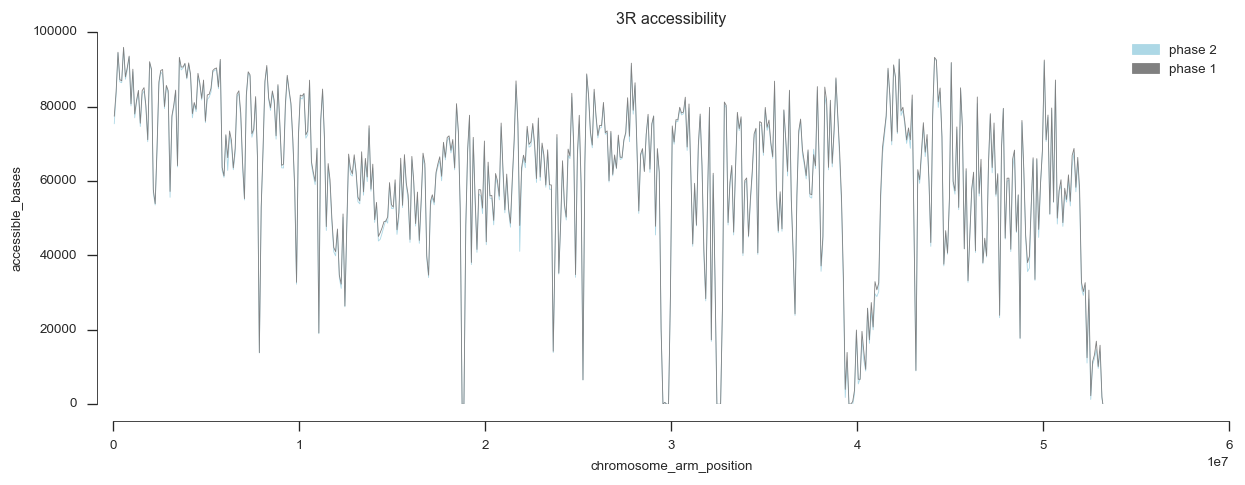

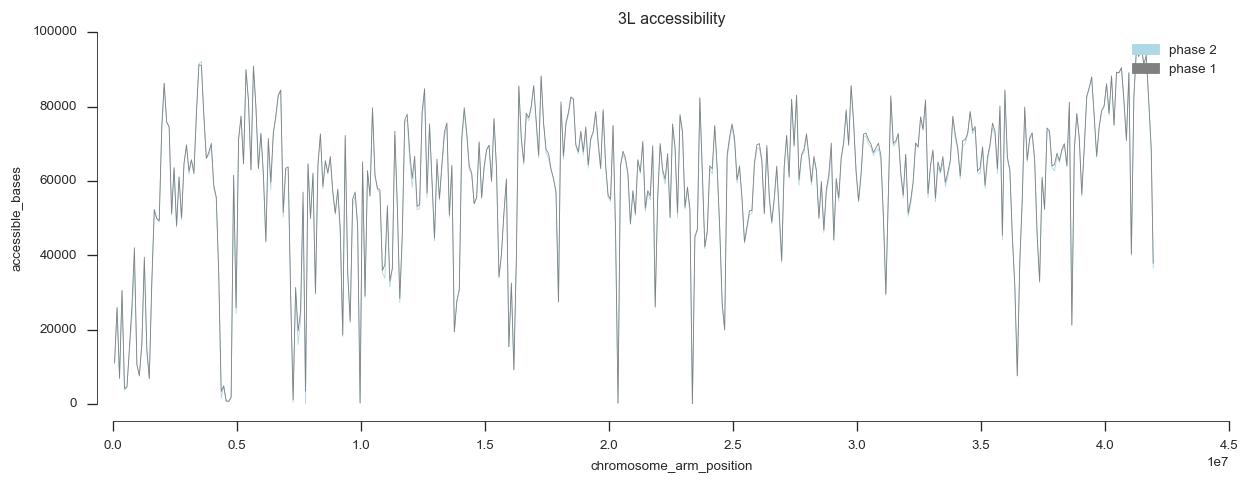

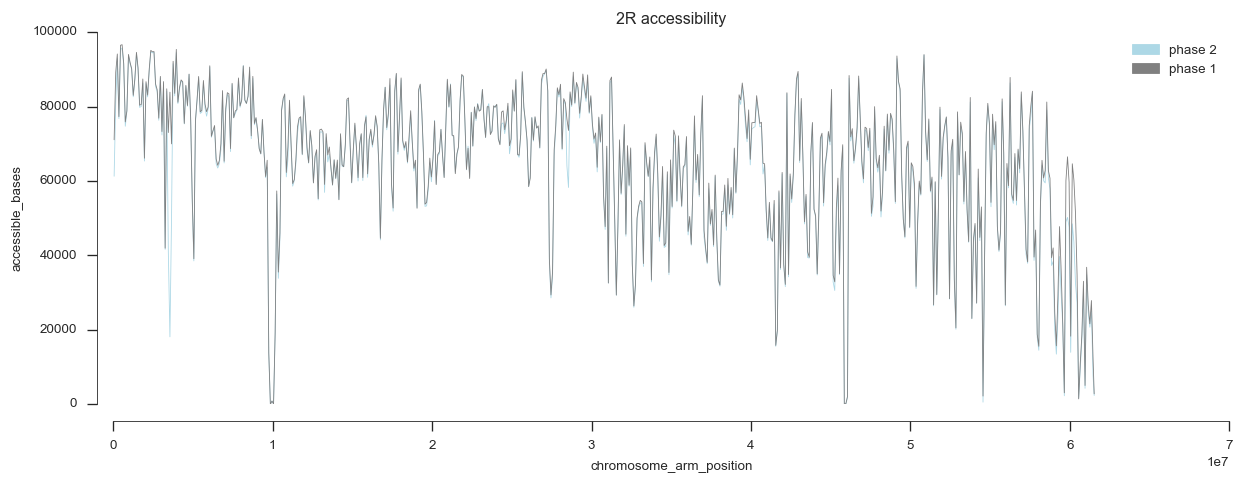

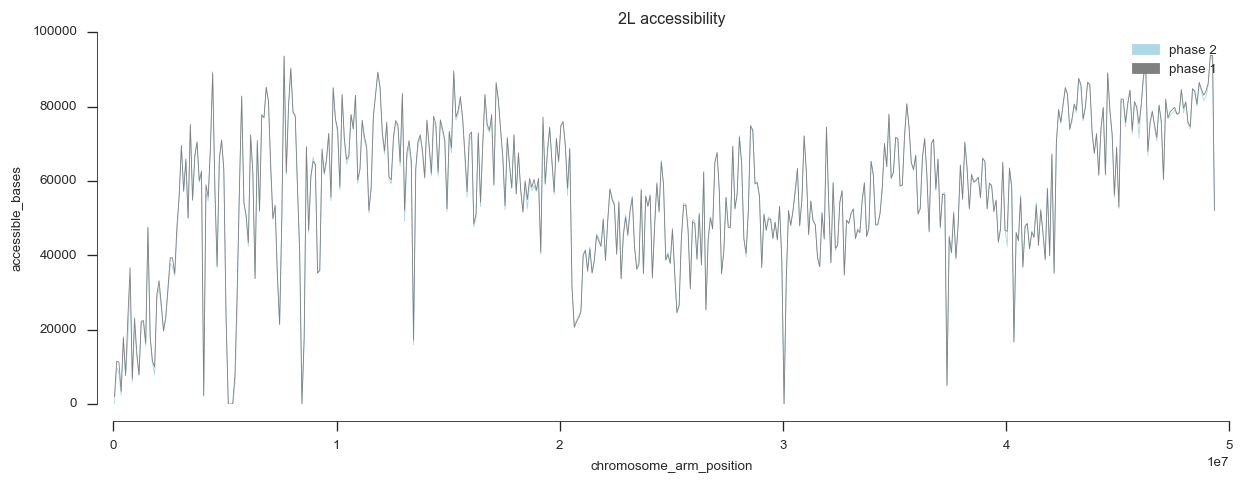

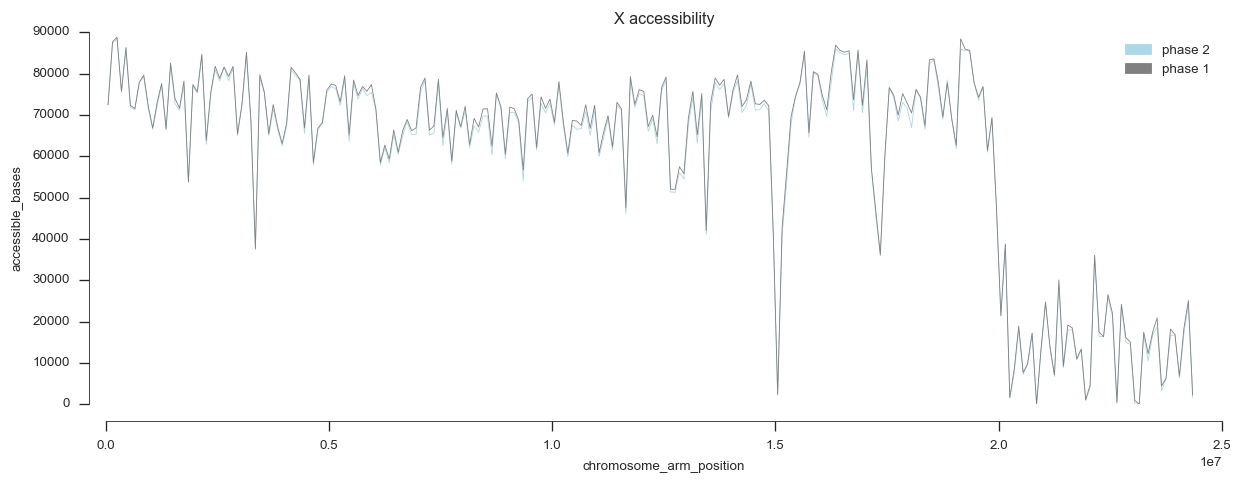

In [85]:
for chrom in '3R', '3L', '2R', '2L', 'X':
    plot_acc_p1_p2(chrom)

# 2.2. Accessibility - coding/non-coding

In [26]:
#which geneset to use?
#if we use the same as p1 we can compare directly - this is also the same on that was used for SNPeff

In [42]:
get_features = release_phase1_ar3.get_features

In [43]:
@functools.lru_cache(maxsize=None)
def load_is_coding(chrom):
    x = np.zeros(len(genome[chrom]), dtype=bool)
    for cds in get_features(chrom).eq('type', 'CDS').records():
        x[cds.start-1:cds.end] = True
    return x

In [76]:
@functools.lru_cache(maxsize=None)
def count_accessible_coding(acc):
    n_accessible = 0
    n = 0
    for chrom in chromosomes:
        is_coding = load_is_coding(chrom)
        is_accessible = acc[chrom]['is_accessible'][:] & is_coding
        n_accessible += np.count_nonzero(is_accessible)
        ref_n = acc[chrom]['ref_n'][:]
        n += np.count_nonzero(is_coding)
    return n_accessible, n, n_accessible / n

In [77]:
#phase 2
count_accessible_coding(acc=accessibility)

(18489202, 20436019, 0.904735995792527)

In [78]:
#phase 1 - matches AMs
count_accessible_coding(acc=accessibility_p1)

(18530705, 20436019, 0.9067668707882881)

In [79]:
@functools.lru_cache(maxsize=None)
def count_accessible_noncoding(acc):
    n_accessible = 0
    n = 0
    for chrom in chromosomes:
        is_coding = load_is_coding(chrom)
        is_accessible = acc[chrom]['is_accessible'][:] & ~is_coding
        n_accessible += np.count_nonzero(is_accessible)
        ref_n = acc[chrom]['ref_n'][:]
        n += np.count_nonzero(~is_coding)
    return n_accessible, n, n_accessible / n


In [80]:
#phase 2
count_accessible_noncoding(acc=accessibility)

(121228531, 210030638, 0.5771945091172841)

In [83]:
#phase 1 - matches AMs
count_accessible_noncoding(acc=accessibility_p1)

(122935171, 210030638, 0.5853201807633418)

# 3.0.  PASS variants - phase 1 vs. phase 2

In [11]:
p1_pass = np.empty([5], dtype=object)
p2_pass = np.empty([5], dtype=object)

p1_total = 0
p2_total = 0
count = 0
for chrom in '2L', '2R', '3L', '3R', 'X':
    p1 = callset_ar2_fn_template.format(chrom=chrom)
    call1 = h5py.File(p1, mode='r')
    pass1 = len(call1[chrom]['variants']['POS'][:])
    p2 = callset_pass_fn_template.format(chrom=chrom)
    call2 = h5py.File(p2, mode='r')
    pass2 = len(call2[chrom]['variants']['POS'][:])
    p1_pass[count] = pass1
    p1_total += pass1
    p2_pass[count] = pass2
    p2_total += pass2
    log(chrom, pass1, pass2)
    count += 1
log('p1-total', p1_total,'p2-total', p2_total)

2016-12-12 15:22:49.801535 :: 2L 10377280 11524923
2016-12-12 15:23:04.449884 :: 2R 14080970 15425222
2016-12-12 15:23:09.149562 :: 3L 9643193 10640388
2016-12-12 15:23:18.756092 :: 3R 13167162 14481509
2016-12-12 15:23:20.964971 :: X 5257352 5765843
2016-12-12 15:23:20.965975 :: p1-total 52525957 p2-total 57837885


In [12]:
p1_pass[0:5]

array([10377280, 14080970, 9643193, 13167162, 5257352], dtype=object)

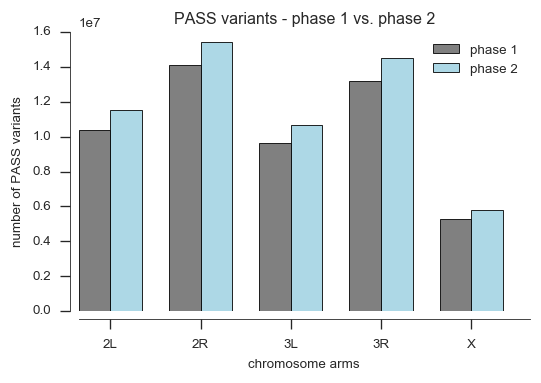

In [13]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5, bottom=False, top=True)
rects1 = ax.bar(ind, p1_pass, width, color='gray')
rects2 = ax.bar(ind + width, p2_pass, width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_ylabel('number of PASS variants')
ax.set_xlabel('chromosome arms')
ax.set_title('PASS variants - phase 1 vs. phase 2')
ax.set_xticks(ind + width)
ax.set_xticklabels(('2L', '2R', '3L', '3R', 'X'))
ax.legend((rects1[0], rects2[0]), ('phase 1', 'phase 2'))
plt.show()

## 377 extra individuals = >5 million more SNPS in phase 2!

# 3.1. PASS variant density

In [149]:
def plot_variant_density(chrom, window=100000):
    h5fn = callset_pass_fn_template.format(chrom=chrom)
    callset_pass = h5py.File(h5fn, mode='r')
    is_accessible = accessibility[chrom]['is_accessible'][:]
    
    v = callset_pass[chrom]['variants']
    pos = v['POS'][:]
    counts, windows = allel.stats.windowed_count(pos, size=window, start=1, stop=len(agamp3_genome[chrom]))
    
    fig, ax = subplots(figsize=(12, 4))
    
    # unadjusted 
    density, n_bases = allel.stats.per_base(counts, windows=windows)
    x = np.mean(windows, axis=1)
    y = density
    ax.plot(x, y)
    
    # adjusted 
    density, n_bases = allel.stats.per_base(counts, windows=windows, is_accessible=is_accessible, fill=np.nan)
    x = np.mean(windows, axis=1)
    y = density
    ax.plot(x, y)
    plt.title(chrom+' density')
    plt.ylabel('variant_density')
    plt.xlabel('chromosome_arm_position')
    green_patch = mpatches.Patch(color='green', label='accessible density')
    blue_patch = mpatches.Patch(color='blue', label='raw density')

    plt.legend(handles=[green_patch, blue_patch])
    plt.show

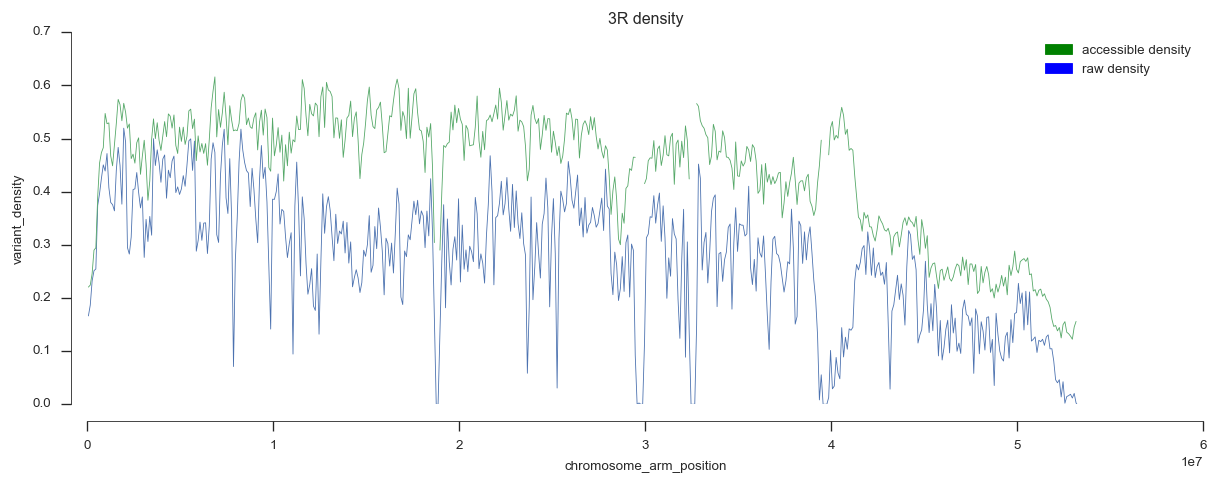

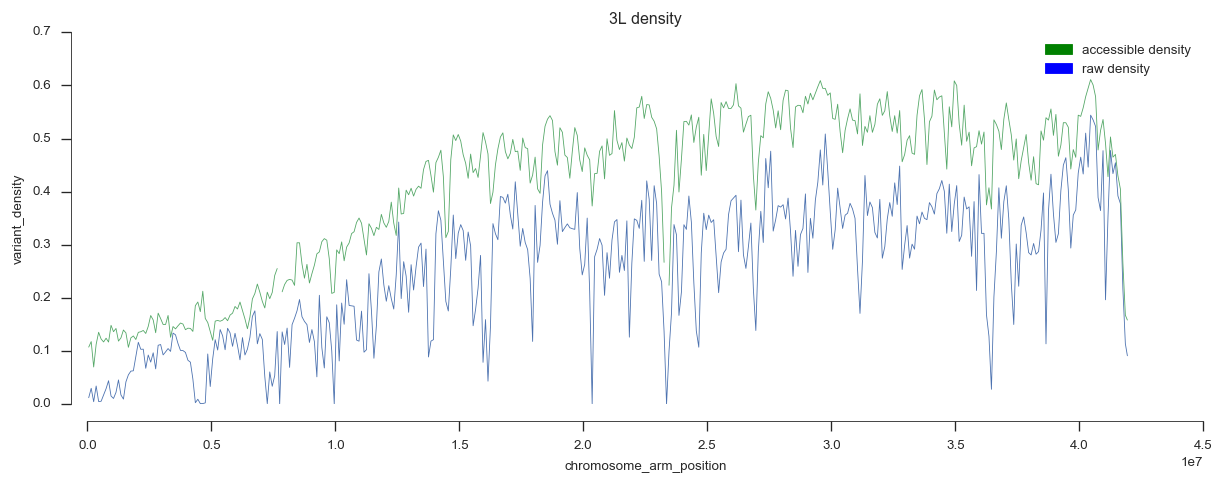

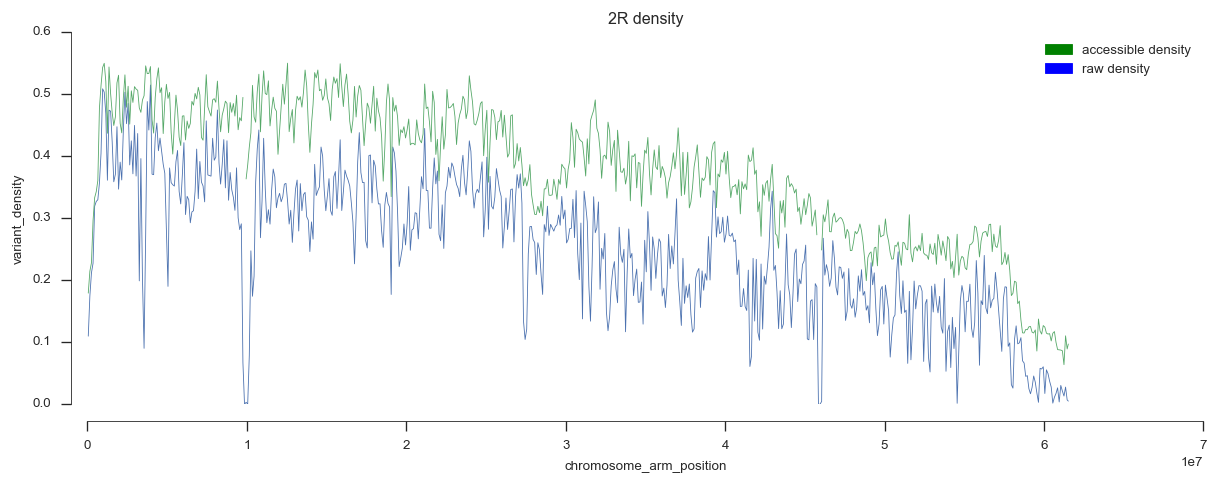

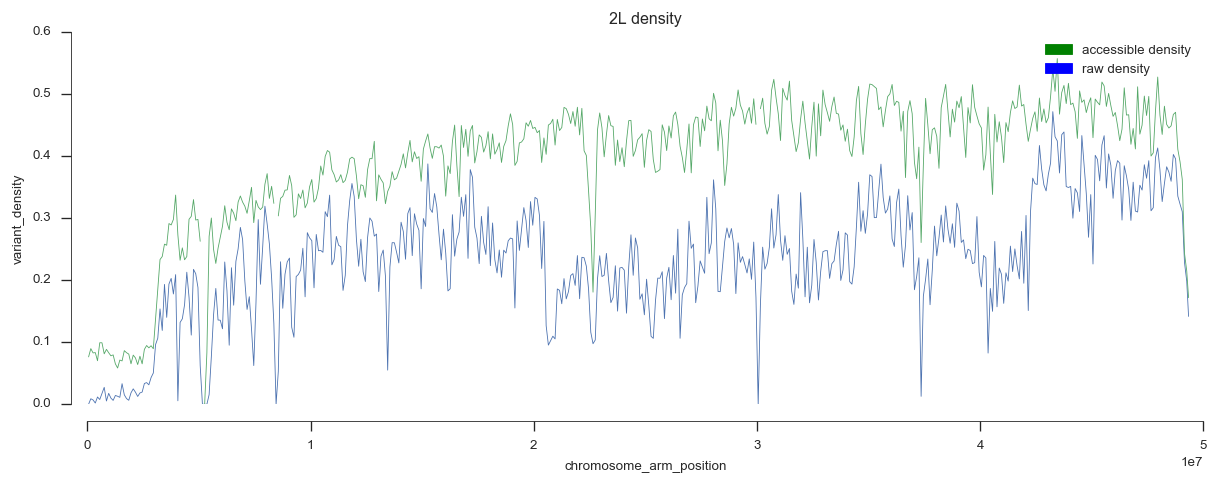

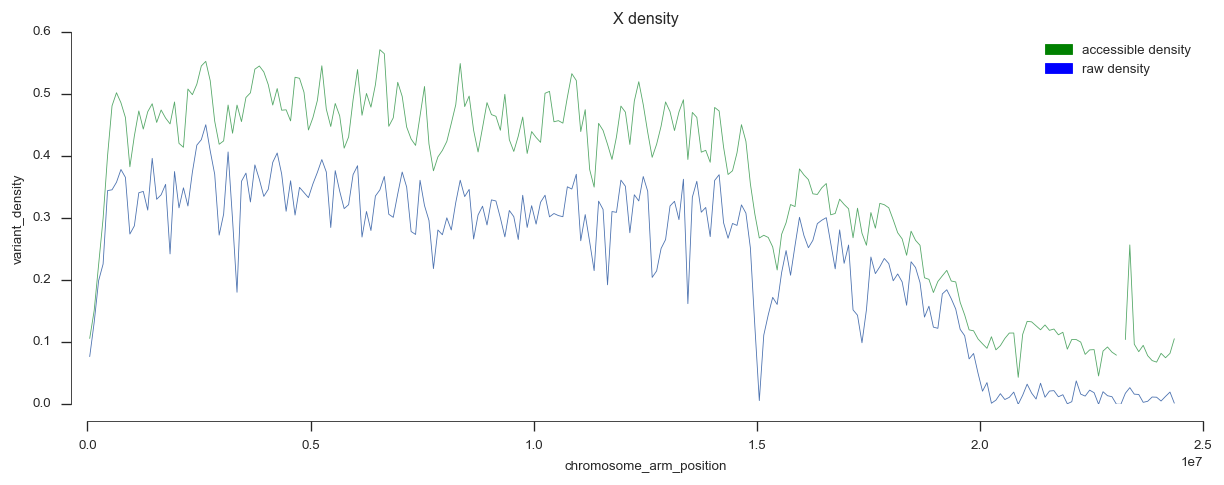

In [150]:
for chrom in '3R', '3L', '2R', '2L', 'X':
    plot_variant_density(chrom)

# 4. Accessible bases per SNP

In [14]:
#phase 2
sum(p2_acc[:,1]) / sum(p2_pass)

2.415678460579947

In [15]:
#phase 1
sum(p1_acc[:,1]) / sum(p1_pass)

2.6932565169636034

# 5.0. Multi allelics

In [36]:
p1_allele = np.empty([5,3], dtype=object)
p2_allele = np.empty([5,3], dtype=object) 
count = 0
for chrom in '2L', '2R', '3L', '3R', 'X':
    p2 = callset_pass_fn_template.format(chrom=chrom)
    call2 = h5py.File(p2, mode='r')
    nall2 = (call2[chrom]['variants']['num_alleles'][:])
    p2_allele[count,0] = np.count_nonzero(nall2 == 2)
    p2_allele[count,1] = np.count_nonzero(nall2 == 3)
    p2_allele[count,2] = np.count_nonzero(nall2 == 4)
    
    p1 = callset_ar2_fn_template.format(chrom=chrom)
    call1 = h5py.File(p1, mode='r')
    nall1 = (call1[chrom]['variants']['num_alleles'][:])
    p1_allele[count,0] = np.count_nonzero(nall1 == 2)
    p1_allele[count,1] = np.count_nonzero(nall1 == 3)
    p1_allele[count,2] = np.count_nonzero(nall1 == 4)
    count += 1

In [44]:
p2_allele.sum(axis=0)[1] + p2_allele.sum(axis=0)[2]

13760984

In [45]:
13760984/57837885*100

23.792336113258635

In [39]:
p2_allele.sum()

57837885

In [38]:
# check numbers with size of biallelic file...SANITY CHECKING H5
for chrom in '2L', '2R', '3L', '3R', 'X':
    p2_ch = callset_biallelic_fn_template.format(chrom=chrom)
    call2_ch = h5py.File(p2_ch, mode='r')
    log(len(call2_ch[chrom]['variants']['POS'][:]))

OSError: Unable to open file (Unable to open file: name = '/kwiat/vector/ag1000g/release/phase2.ar1/variation/main/hdf5/biallelic/ag1000g.phase2.ar1.biallelic.2l.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

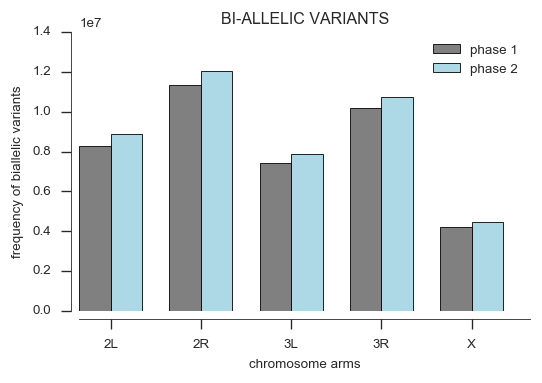

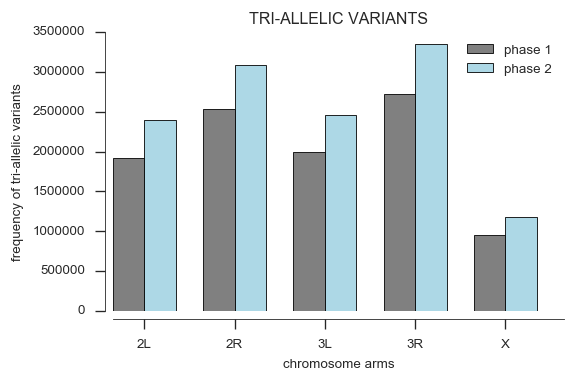

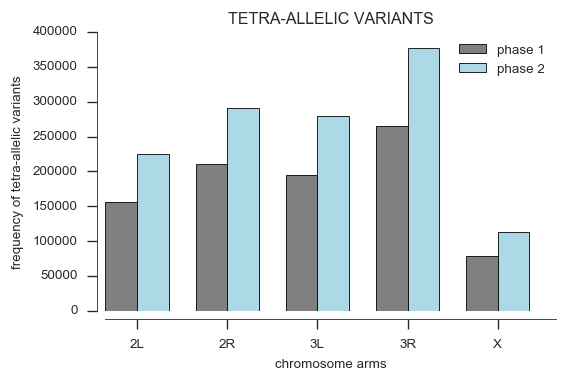

In [19]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5, bottom=False, top=True)
rects1 = ax.bar(ind, p1_allele[:,0], width, color='gray')
rects2 = ax.bar(ind + width, p2_allele[:,0], width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency of biallelic variants')
ax.set_xlabel('chromosome arms')
ax.set_title('BI-ALLELIC VARIANTS')
ax.set_xticks(ind + width)
ax.set_xticklabels(('2L', '2R', '3L', '3R', 'X'))
ax.legend((rects1[0], rects2[0]), ('phase 1', 'phase 2'))
plt.show()

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5, bottom=False, top=True)
rects1 = ax.bar(ind, p1_allele[:,1], width, color='gray')
rects2 = ax.bar(ind + width, p2_allele[:,1], width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency of tri-allelic variants')
ax.set_xlabel('chromosome arms')
ax.set_title('TRI-ALLELIC VARIANTS')
ax.set_xticks(ind + width)
ax.set_xticklabels(('2L', '2R', '3L', '3R', 'X'))
ax.legend((rects1[0], rects2[0]), ('phase 1', 'phase 2'))
plt.show()

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5, bottom=False, top=True)
rects1 = ax.bar(ind, p1_allele[:,2], width, color='gray')
rects2 = ax.bar(ind + width, p2_allele[:,2], width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency of tetra-allelic variants')
ax.set_xlabel('chromosome arms')
ax.set_title('TETRA-ALLELIC VARIANTS')
ax.set_xticks(ind + width)
ax.set_xticklabels(('2L', '2R', '3L', '3R', 'X'))
ax.legend((rects1[0], rects2[0]), ('phase 1', 'phase 2'))
plt.show()

# 5.1 allelic density

In [20]:
@functools.lru_cache(maxsize=None)
def load_acs(chrom):
    """Load allele counts for all subpopulations for the given chromosome."""
    h5_pass = callset_pass_fn_template.format(chrom=chrom)
    callset_pass = h5py.File(h5_pass, mode='r')
    h5_p1 = callset_ar2_fn_template.format(chrom=chrom)
    callset_p1 = h5py.File(h5_p1, mode='r')   
    
    genotype = allel.GenotypeChunkedArray(callset_pass[chrom]['calldata/genotype'])
    ac2 = genotype.count_alleles(max_allele=3)
    
    genotype = allel.GenotypeChunkedArray(callset_p1[chrom]['calldata/genotype'])
    ac1 = genotype.count_alleles(max_allele=3)
    
    return ac2, ac1


@functools.lru_cache(maxsize=None)
def load_alleles(chrom):
    """Load num_alleles for all subpopulations for the given chromosome."""
    h5_pass = callset_pass_fn_template.format(chrom=chrom)
    callset_pass = h5py.File(h5_pass, mode='r')
    h5_p1 = callset_ar2_fn_template.format(chrom=chrom)
    callset_p1 = h5py.File(h5_p1, mode='r')   
    
    num2 = callset_pass[chrom]['variants']['num_alleles'][:]
    num1 = callset_p1[chrom]['variants']['num_alleles'][:]
    pos2 = callset_pass[chrom]['variants']['POS'][:]
    pos1 = callset_p1[chrom]['variants']['POS'][:]
    
    
    return num2, pos2, num1, pos1

In [21]:
def plot_all_per_acc(chrom):
    is_accessible_p2 = accessibility[chrom]['is_accessible'][:]
    is_accessible_p1 = accessibility_p1[chrom]['is_accessible'][:]
    n2,p2,n1,p1 = load_alleles(chrom)
    
    x2, windows2, counts2 = allel.stats.window.windowed_statistic(p2, n2, statistic=np.sum, size=100000, start=None, stop=None, step=None, windows=None)
    x1, windows1, counts1 = allel.stats.window.windowed_statistic(p1, n1, statistic=np.sum, size=100000, start=None, stop=None, step=None, windows=None)
    
    y2, n_bases2 = allel.stats.window.per_base(x2, windows2, is_accessible=is_accessible_p2)
    y1, n_bases1 = allel.stats.window.per_base(x1, windows1, is_accessible=is_accessible_p1)
    
    z2 = np.mean(windows2, axis=1)
    z1 = np.mean(windows1, axis=1)
    
    fig, ax = subplots(figsize=(12, 4))
    
    ax.plot(z2, y2, color='lightblue')
    ax.plot(z1,y1, color='gray')
    plt.title(chrom+' alleles per accessible base')
    plt.ylabel('alleles_per_accessible_base')
    plt.xlabel('chromosome_arm_position')
    green_patch = mpatches.Patch(color='lightblue', label='phase 2')
    blue_patch = mpatches.Patch(color='gray', label='phase 1')

    plt.legend(handles=[green_patch, blue_patch])
    plt.show

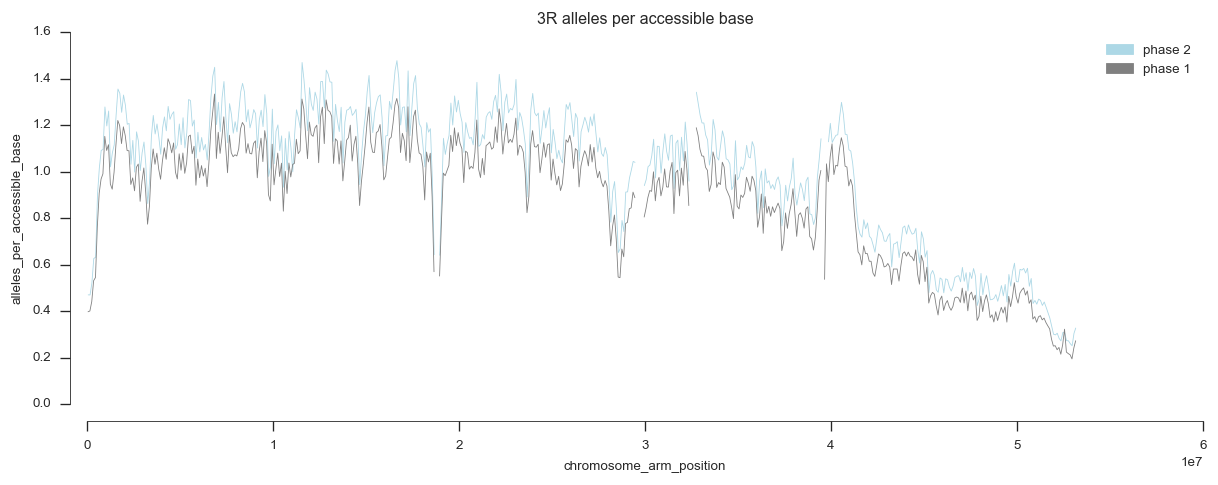

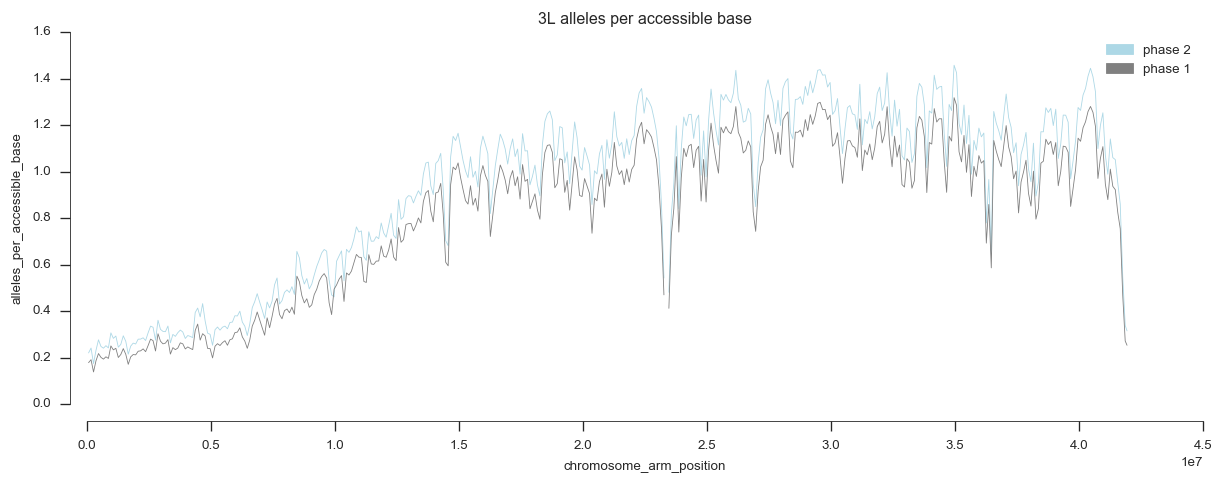

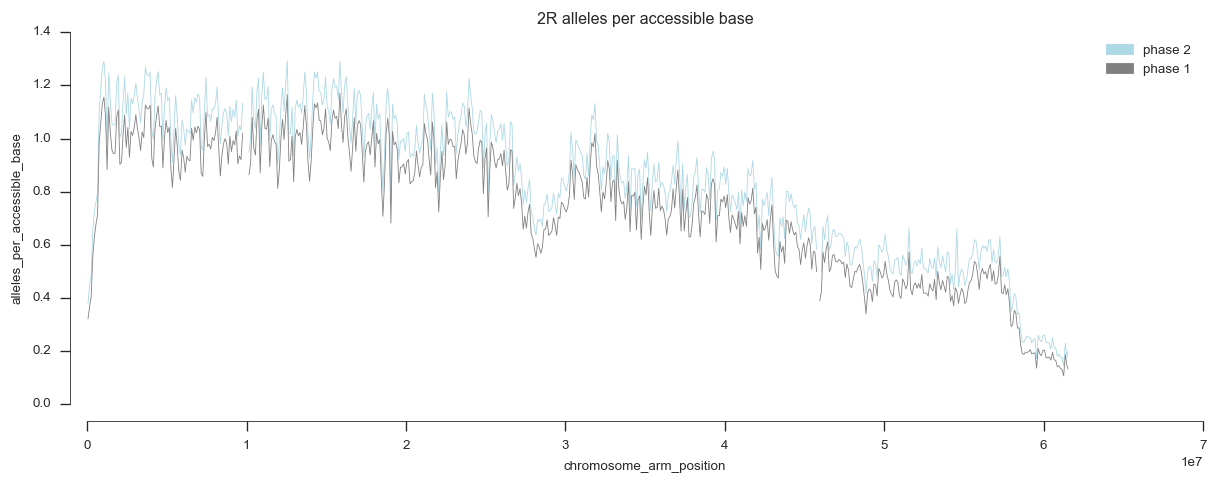

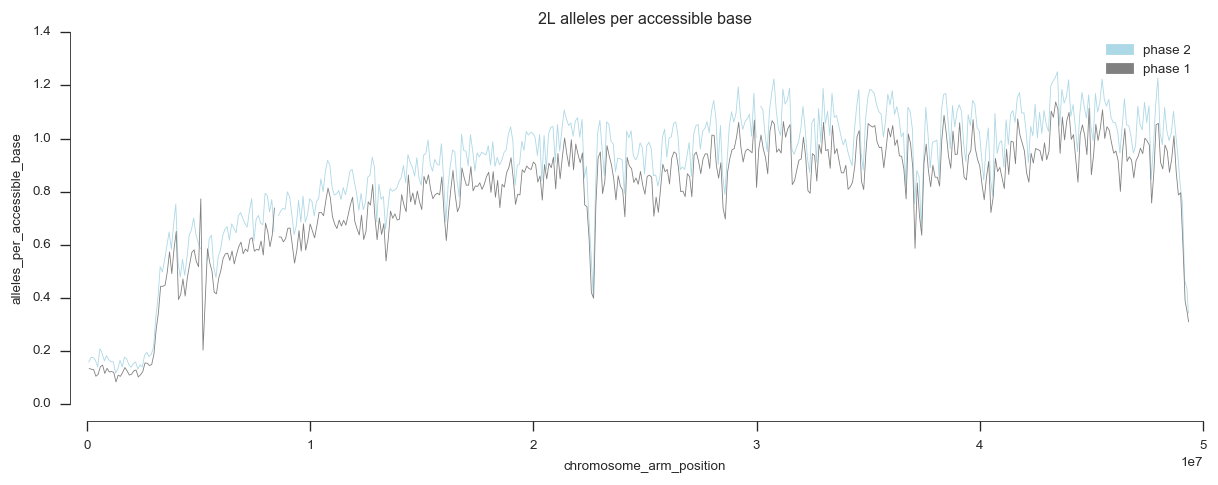

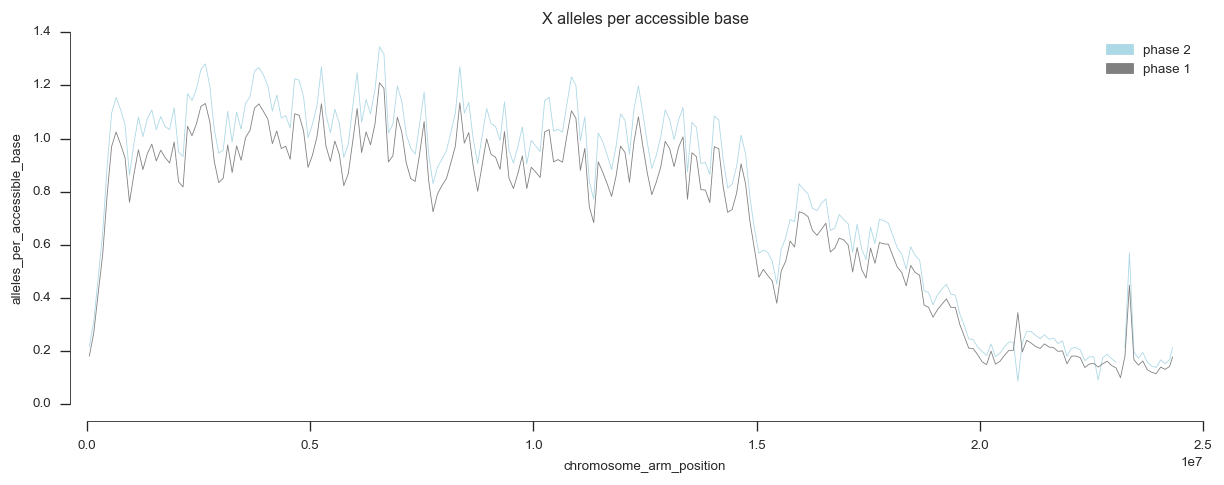

In [157]:
for chrom in '3R', '3L', '2R', '2L', 'X':
    plot_all_per_acc(chrom)

# 5.2 Accessible bases per allele
- this is what is reported in the p1 ms

In [22]:
sum(p2_acc[:,1])

139717733

In [23]:
p1_allele = np.empty([5,1], dtype=object)
p2_allele = np.empty([5,1], dtype=object) 
count = 0
for chrom in '2L', '2R', '3L', '3R', 'X':
    p2 = callset_pass_fn_template.format(chrom=chrom)
    call2 = h5py.File(p2, mode='r')
    nall2 = (call2[chrom]['variants']['num_alleles'][:])
    p2_allele[count] = np.sum(nall2 - 1)
    
    p1 = callset_ar2_fn_template.format(chrom=chrom)
    call1 = h5py.File(p1, mode='r')
    nall1 = (call1[chrom]['variants']['num_alleles'][:])
    p1_allele[count] = np.sum(nall1 - 1)

    count += 1

In [24]:
#phase 2
sum(p2_acc[:,1])/np.sum(p2_allele)

1.9169949269607869

In [25]:
#phase 1
sum(p1_acc[:,1])/np.sum(p1_allele)

2.1938819475968105

### A VARIANT EVERY 1.9 ACCESSIBLE BASES!!

# 6.0. Species

In [6]:
samples_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/samples/tbl_samples.txt'

In [7]:
tbl_samples = (etl.fromtsv(samples_fn))

In [8]:
tbl_samples.valuecounts('m_s')

0|m_s,1|count,2|frequency
S,720,0.6304728546409807
M,287,0.2513134851138354
,113,0.0989492119089317
M/S,22,0.01926444833625219


# 7.0. Populations

In [9]:
pops = tbl_samples.valuecounts('population')
pops.displayall()

0|population,1|count,2|frequency
CMgam,297,0.2600700525394046
UGgam,112,0.09807355516637478
BFgam,92,0.08056042031523643
GW,91,0.0796847635726795
AOcol,78,0.06830122591943957
BFcol,75,0.06567425569176882
CIcol,71,0.06217162872154115
GAgam,69,0.06042031523642732
GM,65,0.05691768826619965
GHcol,55,0.04816112084063047


# 8.0. Countries

In [10]:
pops = tbl_samples.valuecounts('country')
pops.displayall()

0|country,1|count,2|frequency
Cameroon,297,0.2600700525394046
Burkina Faso,167,0.14623467600700527
Uganda,112,0.09807355516637478
Guinea-Bissau,91,0.0796847635726795
Angola,78,0.06830122591943957
Cote d'Ivoire,71,0.06217162872154115
Gabon,69,0.06042031523642732
Ghana,67,0.05866900175131348
"Gambia, The",65,0.05691768826619965
Kenya,48,0.04203152364273205


# 9.0. Regions

In [11]:
pops = tbl_samples.valuecounts('region')
pops.displayall()

0|region,1|count,2|frequency
"Nagongera, Tororo",112,0.09807355516637478
MAYOS,105,0.09194395796847636
DAIGUENE,96,0.0840630472854641
Luanda,78,0.06830122591943957
GADO-BADZERE,73,0.063922942206655
Tiassale,71,0.06217162872154115
Libreville,69,0.06042031523642732
Antula,58,0.050788091068301226
Pala,56,0.04903677758318739
Sour,51,0.0446584938704028


# 10.0. Coverage

In [153]:
tbl_samples = tbl_samples.convert('contamination_freemix_autosomal_not2L_dpflt', 
         lambda v: -1 if v is '' else v).convert(('bamcheck_sequences', 
         'vrpipe_mean_coverage',
         'vrpipe_pc_genome_covered',
         'bamcheck_mapped_reads_pc_duplicated', 
         'bamcheck_error_rate',
         'bamcheck_reads_pc_mapped', 
         'bamcheck_reads_pc_unmapped', 
         'contamination_freemix_phase2',
         'contamination_freemix_autosomal_not2L_dpflt'), float)

tbl_samples.display(2)

0|ox_code,1|population,2|solaris_sample_id,3|src_code,4|country,5|region,6|contributor,7|contact,8|year,9|m_s,10|sex,11|volume,12|concentration,13|total_dna,14|dna_quant_method,15|notes,16|2Rj,17|2Rb,18|2Rc,19|2Rd,20|2Ru,21|2La,22|build_1000g_09_13,23|build_1000g_12_09,24|bamcheck_1st_fragments,25|bamcheck_average_length,26|bamcheck_average_quality,27|bamcheck_bases_duplicated,28|bamcheck_bases_mapped,29|bamcheck_bases_mapped_cigar,30|bamcheck_bases_trimmed,31|bamcheck_error_rate,32|bamcheck_insert_size_average,33|bamcheck_insert_size_standard_deviation,34|bamcheck_inward_oriented_pairs,35|bamcheck_is_paired,36|bamcheck_is_sorted,37|bamcheck_last_fragments,38|bamcheck_maximum_length,39|bamcheck_mismatches,40|bamcheck_outward_oriented_pairs,41|bamcheck_pairs_with_other_orientation,42|bamcheck_reads_MQ0,43|bamcheck_reads_duplicated,44|bamcheck_reads_mapped,45|bamcheck_reads_paired,46|bamcheck_reads_unmapped,47|bamcheck_reads_unpaired,48|bamcheck_sequences,49|bamcheck_total_length,50|bamcheck_reads_pc_mapped,51|bamcheck_reads_pc_unmapped,52|bamcheck_mapped_reads_pc_paired,53|bamcheck_mapped_reads_pc_unpaired,54|bamcheck_mapped_reads_pc_duplicated,55|bamcheck_mapped_reads_pc_MQ0,56|vrpipe_path,57|vrpipe_bases_of_1X_coverage,58|vrpipe_bases_of_2X_coverage,59|vrpipe_bases_of_5X_coverage,60|vrpipe_bases_of_10X_coverage,61|vrpipe_bases_of_20X_coverage,62|vrpipe_bases_of_50X_coverage,63|vrpipe_bases_of_100X_coverage,64|vrpipe_avg_read_length,65|vrpipe_bases,66|vrpipe_bases_mapped,67|vrpipe_bases_trimmed,68|vrpipe_filtered_reads,69|vrpipe_forward_reads,70|vrpipe_reverse_reads,71|vrpipe_insert_size,72|vrpipe_mean_insert_size,73|vrpipe_sd_insert_size,74|vrpipe_mean_coverage,75|vrpipe_paired,76|vrpipe_population,77|vrpipe_study,78|vrpipe_reads,79|vrpipe_reads_mapped,80|vrpipe_reads_paired,81|vrpipe_rmdup_bases,82|vrpipe_rmdup_bases_mapped,83|vrpipe_rmdup_reads,84|vrpipe_rmdup_reads_mapped,85|vrpipe_error_rate,86|vrpipe_pc_genome_covered,87|contamination_freemix_phase2,88|contamination_freemix_3L_100kb,89|contamination_freemix_autosomal,90|contamination_freemix_autosomal_not2L,91|contamination_freemix_autosomal_not2L_dpflt,92|number_of_unique_libraries,93|number_of_lanes,94|earliest_sequencing_date,95|latest_sequencing_date,96|libraries,97|lane_file_solaris_ids,98|lane_file_names,99|SRA_sample_accession
AA0040-C,GHM,33070,Twifo_Praso__E2,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,60.0,4.25088,255.0528,Picogreen,Plate1_A_2,,,,,,,False,True,47516684.0,100.0,34.8,530781800.0,8386857200.0,8249187877.0,0.0,0.01971637,242.2,78.6,40436677.0,1.0,1.0,47516684.0,100.0,162644005.0,111498.0,182737.0,12074941.0,5307818.0,83868572.0,81463658.0,11164796.0,2404914.0,95033368.0,9503336800.0,88.25170965212976,11.748290347870235,97.13252063001622,2.8674793699837884,6.328733008593493,14.397456296263158,/lustre/scratch110/malaria/ag1000g/output/f/b/1/0/137924/2_gatk_indel_realigner_gatk2/pe.1.reali.bam,246734129.0,244356890.0,238841112.0,230049596.0,202848547.0,9989384.0,2379558.0,100.0,9503336800.0,8386857200.0,0.0,95033368.0,47516684.0,47516684.0,0.0,242.2,78.6,30.99,1.0,Ag 1000g,Ag 1000g,95033368.0,83868572.0,81463658.0,8972555000.0,7727118801.0,89725550.0,78560754.0,0.01971637,90.34779863690805,0.0007099999999999999,,,,-1.0,1.0,3.0,2013-09-18,2013-09-23,DN297401L:G2,"45853,47265,47578","10798_2#15.bam,10843_3#15.bam,10843_4#15.bam",ERS311878
AA0041-C,GHM,33071,Twifo_Praso__H3,Ghana,Twifo_Praso,David Weetman,,2012.0,M,F,60.0,3.4956600000000004,209.7396,Picogreen,Plate1_A_3,,,,,,,False,True,47921902.0,100.0,34.8,323069400.0,8257947800.0,8114347817.0,0.0,0.02058724,236.0,72.8,39852809.0,1.0,1.0,47921902.0,100.0,167052049.0,109839.0,179326.0,10919112.0,3230694.0,82579478.0,80285062.0,13264326.0,2294416.0,95843804.0,9584380400.0,86.16047626824161,13.839523731758392,97.22156635574758,2.7784336442523894,3.912223809406981,13.222549069636884,/lustre/scratch110/malaria/ag1000g/output/a/9/1/e/137821/2_gatk_indel_realigner_gatk2/pe.1.reali.bam,246188691.0,243155035.0,

In [154]:
#take the columns of interest and turn them into a recarray - 
#this is a numpy structure that acts like a spreadsheet with
#columns and rows (y and x)

A = tbl_samples.torecarray()

In [155]:
#load dictionary from table with one row for each key
lkp_sample = tbl_samples.recordlookupone('ox_code')

In [158]:
from matplotlib.ticker import *
from matplotlib.colors import *

def hist_samples(x_var, figsize=(10,3), label_samples=[], color='w',**kwargs):
    #size of figure
    fig = plt.figure(figsize=figsize)
    #how many plots and where - like par(mfrow) in R, here 111 means a 1x1 plot in position 1
    ax = fig.add_subplot(111)
    #numexpr is basically doing A['column'] but allows interaction e.g. A['column1/column2']
    X = numexpr.evaluate(x_var, local_dict=A)
    ax.hist(X, color=color, **kwargs)
    ax.set_xlabel(x_var)
    ax.set_ylabel('frequency')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
         
    for sid in label_samples:
        s = lkp_sample[sid]
        x = s[x_var]
        y = 0
        lbl = '%s/%s (%s/%s)' % (sid, s.src_code, s.country, s.region)
        ax.annotate(lbl, xy=(x, y), rotation=90, xycoords='data', xytext=(0, -28), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    return ax
    

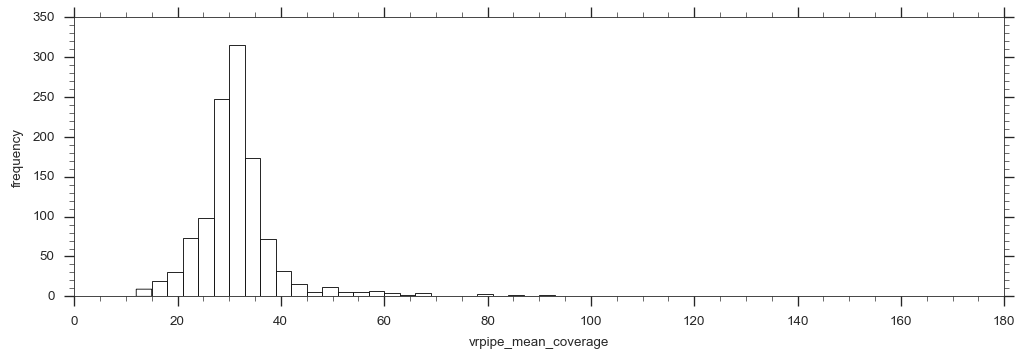

In [165]:
x_var = 'vrpipe_mean_coverage'  # total number of sequence reads, i.e., yield
hist_samples(x_var, bins=50)

In [160]:
X = numexpr.evaluate('vrpipe_mean_coverage', local_dict=A)

In [175]:
np.amin(X), np.amax(X), np.mean(X), np.median(X)

(12.01, 162.09, 31.87216287215411, 30.899999999999999)

# 11.0. Principal component analysis

In [12]:
import random
random.seed(42)
import time
np.random.seed(42)

In [13]:
callset_fn = '/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/biallelic/ag1000g.phase2.ar1.biallelic.3L.h5'
callset = h5py.File(callset_fn, mode='r')

#get samples
df_samples = pandas.read_csv('/kwiat/vector/ag1000g/release/phase2.AR1/samples/tbl_samples.txt', delimiter='\t')
all_samp=list(df_samples.ox_code)

regions = (("3R", 1000000, 37000000, "free"),
           ("3L", 15000000, 41000000, "free"))

chrom = '3L'

#get genotypes
g = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])

#get positions
p = allel.VariantChunkedTable(callset[chrom]['variants'],
                                 names=['POS'],
                                 index='POS')
pos = p.POS[:]

#just keep positions within the free region
pos_free = pos[(pos > 15000000) * (pos < 41000000)] 
free_b = p.index.locate_keys(pos_free)
g_snp = g.compress(free_b, axis=0)

#filter - no missing data
ac = g_snp.count_alleles()
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g_snp.compress(flt, axis=0)

#turn the genotype array into 2D matrix of non_ref alleles per call
gn = gf.to_n_alt()

#randomly select snps
n = 100000
vidx = np.random.choice(gn.shape[0], n, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)

In [14]:
#LD prune
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.stats.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [ ]:
gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=10)

iteration 1 retaining 66272 removing 33728 variants
iteration 2 retaining 59390 removing 6882 variants
iteration 3 retaining 57090 removing 2300 variants
iteration 4 retaining 56010 removing 1080 variants
iteration 5 retaining 55349 removing 661 variants
iteration 6 retaining 54942 removing 407 variants
iteration 7 retaining 54646 removing 296 variants


In [ ]:
#performed PCA
coords1, model1 = allel.stats.pca(gnu, n_components=20, scaler='patterson')

In [27]:
pop_colours = {
    'AOcol': '#9f3703',
    'BFcol': '#f67824',
    'BFgam': '#562c91',
    'CIcol': '#feb13f',
    'CMgam': '#705da9',
    'FRgam': '#0b559f',
    'GAgam': '#2a7ab9',
    'GHcol': '#f44e38',
    'GHgam': '#88bedc',
    'GM': '#5b5b5b',
    'GNcol': '#a91016',
    'GNgam': '#8ed08b',
    'GQgam': '#56b567',
    'GW': '#acacac',
    'KE': '#2a2a2a',
    'UGgam': '#04702f'
}


marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

In [28]:
all_samp=list(df_samples.ox_code)
len(all_samp)

1142

In [29]:
populations = df_samples.population.unique()
populations, len(df_samples.population)

(array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'UGgam', 'GM', 'GW', 'KE',
        'CMgam', 'FRgam', 'GQgam', 'AOcol', 'GAgam', 'GNgam', 'GNcol',
        'CIcol'], dtype=object), 1142)

In [30]:
#dictionary+list comprehension to create a dictionary of lists of indexes!
idx_dict = {popz: [i for i, j in enumerate(all_samp) if j == popz] for popz in populations}

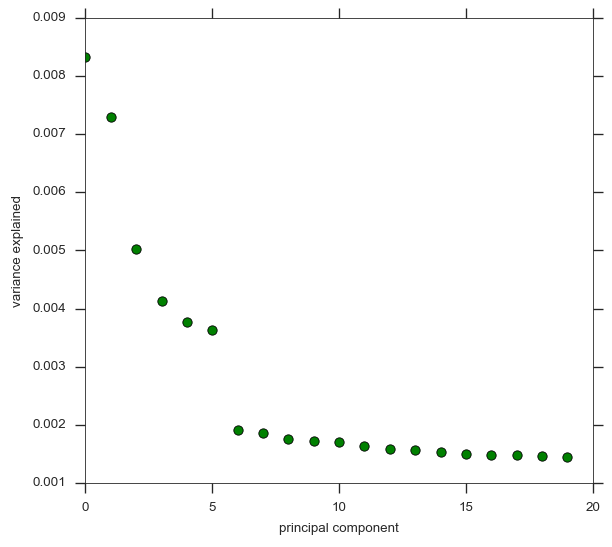

In [31]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.plot(model1.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")

In [32]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style[pop], linestyle=' ', color=pop_colours[pop], label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    fn = 'Phase_2_'+chrom+'_pca.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

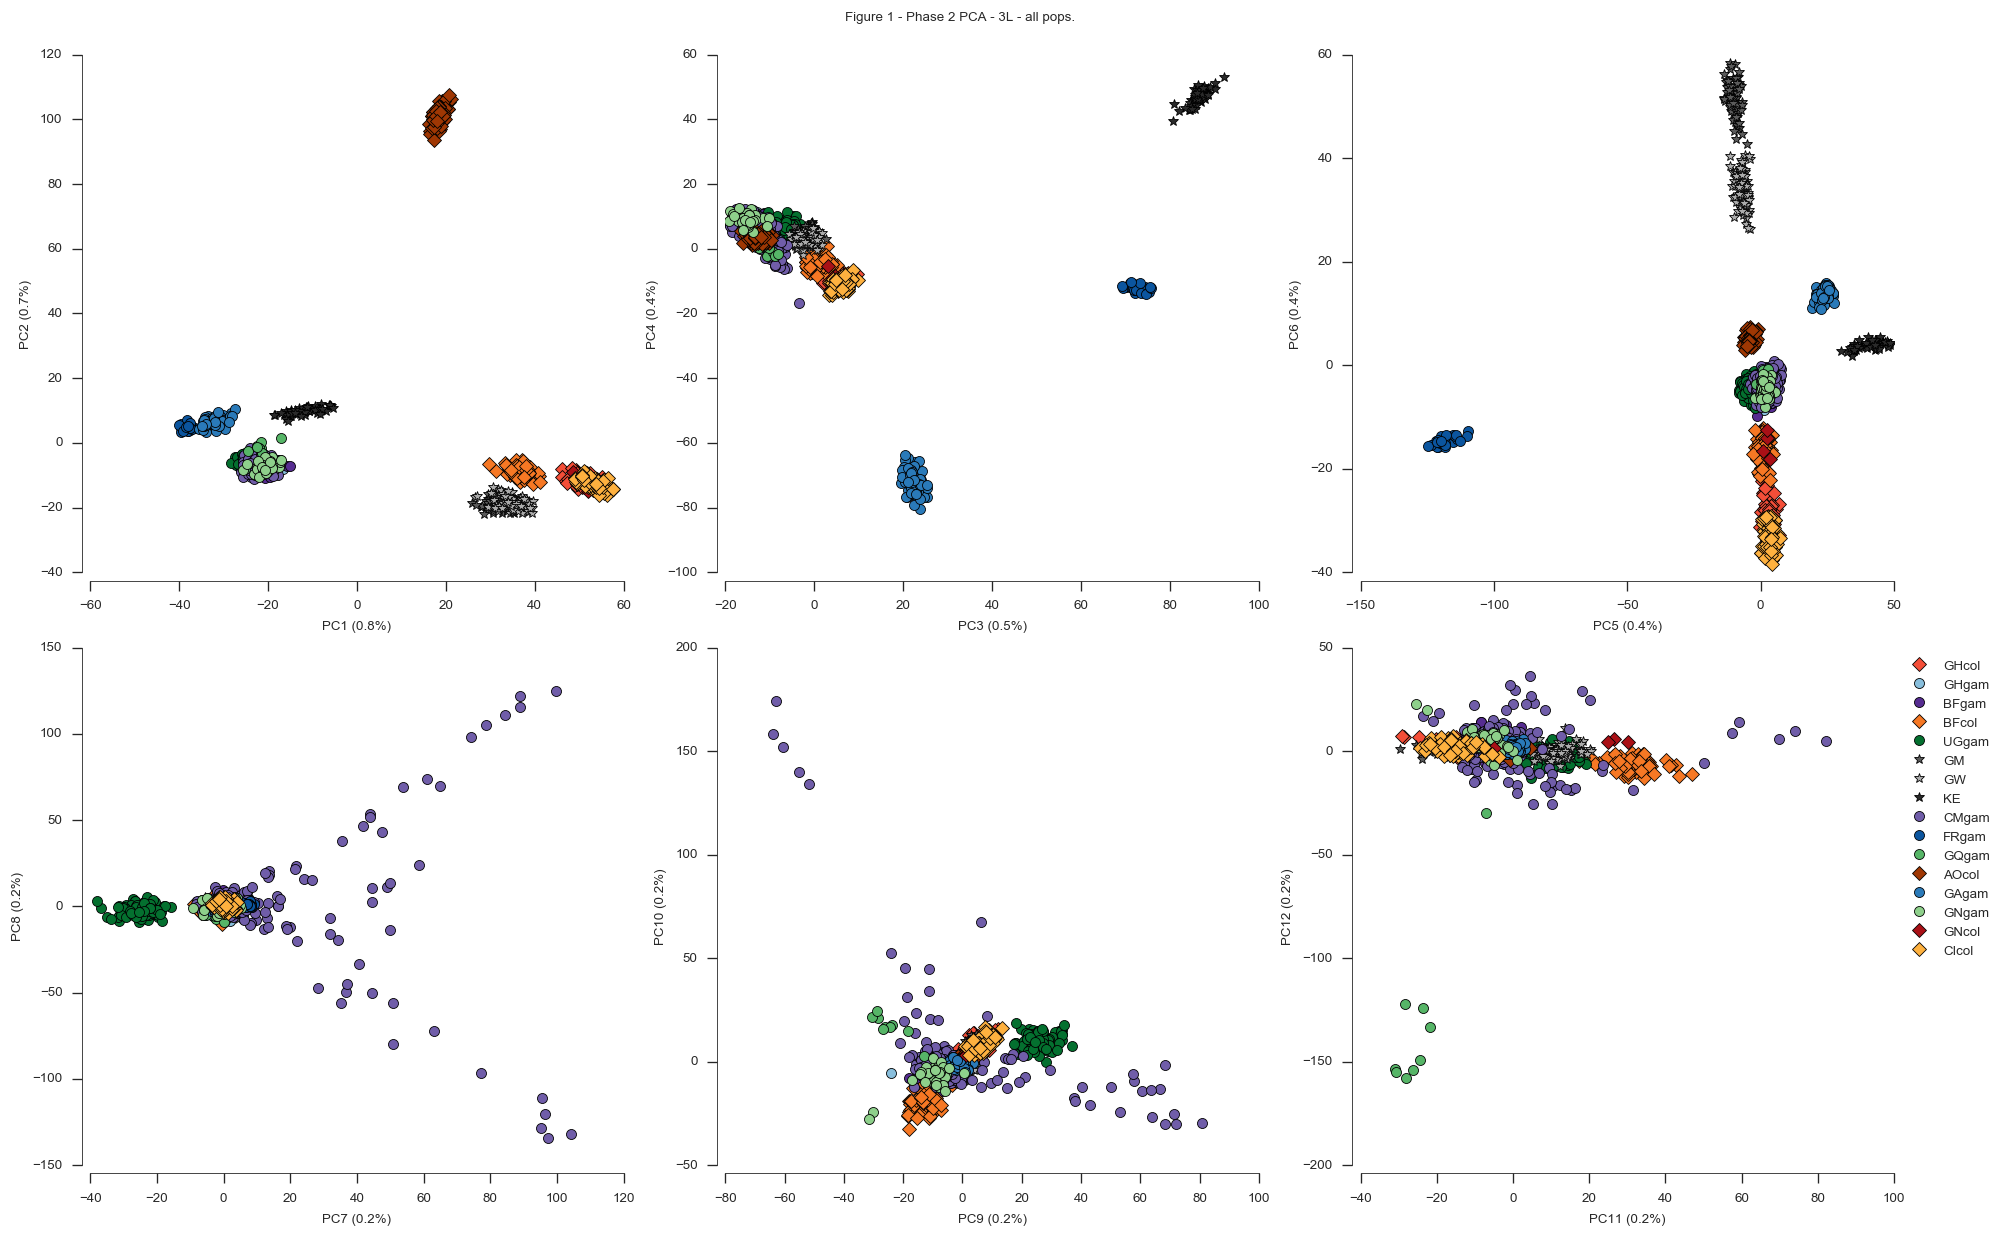

In [33]:
fig_pca(coords1, model1.explained_variance_ratio_ ,'Figure 1 - Phase 2 PCA - 3L - all pops.', df_samples.population.values)